# Models: Decision Tree, Random Forest

In [1]:
# Import relevant packages
import matplotlib.pyplot as plt
%matplotlib inline

import inspect
from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve, plot_precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from utils import process_data, compare_models, grid_search, get_gridsearch_results, split_train

In [2]:
data = process_data(type_ = 'normal')

Beginning data processing ...
Reading in batched data ...


100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  3.06it/s]


Splitting data into train and test ...
Scaling data ...
Completed normal data processing.


In [3]:
X_train = data['X_train_scaled']
y_train = data['y_train']

X_test = data['X_test_scaled']
y_test = data['y_test']

## Useful Functions

In [4]:
def plot_roc_auc(clf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
    auc_ = auc(fpr, tpr)

    ax1.plot([0, 1], [0, 1], '--')
    ax1.plot(fpr, tpr, label='area = {:.3f}'.format(auc_))
    ax1.set_xlabel('False positive rate')
    ax1.set_ylabel('True positive rate')
    ax1.set_title("Train ROC AUC")
    ax1.legend(loc='best')

    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    auc_ = auc(fpr, tpr)

    ax2.plot([0, 1], [0, 1], '--')
    ax2.plot(fpr, tpr, label='area = {:.3f}'.format(auc_))
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.set_title("Test ROC AUC")
    
    ax2.legend(loc='best')
    plt.show()

In [33]:
def plot_importances(clf):
    importances_impurity = clf.feature_importances_
    impurity_importances = pd.Series(importances_impurity).nlargest(10) 
    # select the 10 X variables with largest feature importance values
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    impurity_importances.plot.bar(ax=ax1)
    ax1.set_title("Feature importances using MDI (mean decrease in impurity)")
    ax1.set_ylabel("Mean decrease in impurity")

# Check decision tree training results on subsetted data

In [6]:
# Specify scoring criterion
criterion = make_scorer(roc_auc_score, needs_proba=True)
clf_tree = DecisionTreeClassifier()

param_grid = dict(criterion=['entropy'],
                  max_depth=[2, 5, 10],
                  ccp_alpha=[0, 0.00001, 0.0001])

percents = [0.02, 0.05, 0.1, 0.15]

In [7]:
for percent in percents:
    X, y = split_train(X_train, y_train, percent)
    grid_result_tree = grid_search(clf_tree, criterion, param_grid, k=5, X=X, y=y, verbose=False)

    # Choose best parameters from hyperparameter tuning
    clf_tree = grid_result_tree.best_estimator_

    # save best decision tree model
    pickle.dump(grid_result_tree, open(f'small_models/grid_tree_{percent}.sav', 'wb'))
    pickle.dump(clf_tree, open(f'small_models/model_tree_{percent}.sav', 'wb'))

Keep 2.0% train data ...
Keep 5.0% train data ...
Keep 10.0% train data ...
Keep 15.0% train data ...


<AxesSubplot:>

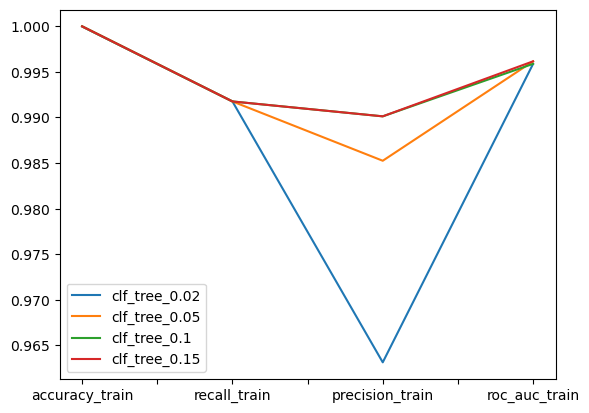

In [8]:
clfs = []
clf_names = []
for percent in percents:
    clf_tree = pickle.load(open(f'small_models/model_tree_{percent}.sav', 'rb'))
    clfs.append(clf_tree)
    clf_names.append(f'clf_tree_{percent}')
    
res_df = compare_models(clfs, clf_names, X_test, y_test, X_test, y_test)
res_df.iloc[:4].plot()

# Decide which models to train

In [9]:
train_tree = True
train_rf = True
train_ada = True
keep_percent = 0.1

X, y = split_train(X_train, y_train, keep_percent)

Keep 10.0% train data ...


## Decision Tree Model

In [10]:
print(inspect.signature(DecisionTreeClassifier))

(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)


In [11]:
if train_tree:
    # Specify scoring criterion
    criterion = make_scorer(roc_auc_score, needs_proba=True)

    clf_tree = DecisionTreeClassifier()

    param_grid = dict(criterion=['entropy'],
                      max_depth=[2, 5, 10, 15],
                      ccp_alpha=[0, 1e-5, 1e-4, 1e-3, 3e-3, 5e-3])

    grid_result_tree = grid_search(clf_tree, criterion, param_grid, k=5, X=X, y=y)
    
    # Choose best parameters from hyperparameter tuning
    clf_tree = grid_result_tree.best_estimator_
    
    # save best decision tree model
    pickle.dump(grid_result_tree, open('small_models/grid_tree.sav', 'wb'))
    pickle.dump(clf_tree, open('small_models/model_tree.sav', 'wb'))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START ccp_alpha=0, criterion=entropy, max_depth=2................
[CV 1/5; 1/24] END ccp_alpha=0, criterion=entropy, max_depth=2;, score=1.000 total time=   0.8s
[CV 2/5; 1/24] START ccp_alpha=0, criterion=entropy, max_depth=2................
[CV 2/5; 1/24] END ccp_alpha=0, criterion=entropy, max_depth=2;, score=1.000 total time=   0.7s
[CV 3/5; 1/24] START ccp_alpha=0, criterion=entropy, max_depth=2................
[CV 3/5; 1/24] END ccp_alpha=0, criterion=entropy, max_depth=2;, score=0.989 total time=   0.4s
[CV 4/5; 1/24] START ccp_alpha=0, criterion=entropy, max_depth=2................
[CV 4/5; 1/24] END ccp_alpha=0, criterion=entropy, max_depth=2;, score=1.000 total time=   0.7s
[CV 5/5; 1/24] START ccp_alpha=0, criterion=entropy, max_depth=2................
[CV 5/5; 1/24] END ccp_alpha=0, criterion=entropy, max_depth=2;, score=0.989 total time=   0.7s
[CV 1/5; 2/24] START ccp_alpha=0, criterion=entropy, 

[CV 1/5; 10/24] END ccp_alpha=0.0001, criterion=entropy, max_depth=5;, score=1.000 total time=   0.8s
[CV 2/5; 10/24] START ccp_alpha=0.0001, criterion=entropy, max_depth=5..........
[CV 2/5; 10/24] END ccp_alpha=0.0001, criterion=entropy, max_depth=5;, score=1.000 total time=   0.8s
[CV 3/5; 10/24] START ccp_alpha=0.0001, criterion=entropy, max_depth=5..........
[CV 3/5; 10/24] END ccp_alpha=0.0001, criterion=entropy, max_depth=5;, score=0.989 total time=   0.4s
[CV 4/5; 10/24] START ccp_alpha=0.0001, criterion=entropy, max_depth=5..........
[CV 4/5; 10/24] END ccp_alpha=0.0001, criterion=entropy, max_depth=5;, score=1.000 total time=   0.8s
[CV 5/5; 10/24] START ccp_alpha=0.0001, criterion=entropy, max_depth=5..........
[CV 5/5; 10/24] END ccp_alpha=0.0001, criterion=entropy, max_depth=5;, score=0.980 total time=   0.8s
[CV 1/5; 11/24] START ccp_alpha=0.0001, criterion=entropy, max_depth=10.........
[CV 1/5; 11/24] END ccp_alpha=0.0001, criterion=entropy, max_depth=10;, score=1.000 t

[CV 1/5; 19/24] END ccp_alpha=0.003, criterion=entropy, max_depth=10;, score=1.000 total time=   0.8s
[CV 2/5; 19/24] START ccp_alpha=0.003, criterion=entropy, max_depth=10..........
[CV 2/5; 19/24] END ccp_alpha=0.003, criterion=entropy, max_depth=10;, score=1.000 total time=   0.8s
[CV 3/5; 19/24] START ccp_alpha=0.003, criterion=entropy, max_depth=10..........
[CV 3/5; 19/24] END ccp_alpha=0.003, criterion=entropy, max_depth=10;, score=0.989 total time=   0.4s
[CV 4/5; 19/24] START ccp_alpha=0.003, criterion=entropy, max_depth=10..........
[CV 4/5; 19/24] END ccp_alpha=0.003, criterion=entropy, max_depth=10;, score=1.000 total time=   0.8s
[CV 5/5; 19/24] START ccp_alpha=0.003, criterion=entropy, max_depth=10..........
[CV 5/5; 19/24] END ccp_alpha=0.003, criterion=entropy, max_depth=10;, score=0.980 total time=   0.7s
[CV 1/5; 20/24] START ccp_alpha=0.003, criterion=entropy, max_depth=15..........
[CV 1/5; 20/24] END ccp_alpha=0.003, criterion=entropy, max_depth=15;, score=1.000 to

In [12]:
if train_tree:
    display(get_gridsearch_results(grid_result_tree))

,ccp_alpha,criterion,max_depth,criterion_result
0,0,entropy,2,0.995632
1,0,entropy,5,0.995869
2,0,entropy,10,0.995869
3,0,entropy,15,0.995869
4,0.00001,entropy,2,0.995632
5,0.00001,entropy,5,0.995869
6,0.00001,entropy,10,0.995869
7,0.00001,entropy,15,0.995869
8,0.0001,entropy,2,0.993828
9,0.0001,entropy,5,0.993828


In [13]:
# read best decision tree model
clf_tree = pickle.load(open('small_models/model_tree.sav', 'rb'))

## Random Forest Model

In [14]:
print(inspect.signature(RandomForestClassifier))

(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


In [16]:
if train_rf:
    # Specify scoring criterion
    criterion = make_scorer(roc_auc_score, needs_proba=True)

    clf_rf = RandomForestClassifier()

    param_grid = dict(criterion=['entropy'],
                      max_depth=[2, 5, 10, 15],
                      ccp_alpha=[0, 1e-5, 1e-4, 1e-3, 5e-3],
                      n_estimators=[50, 100, 150, 200]
                      )

    grid_result_rf = grid_search(clf_rf, criterion, param_grid, k=5, X=X, y=y)
    
    # Choose best parameters from hyperparameter tuning
    clf_rf = grid_result_rf.best_estimator_

    # save best decision tree model
    pickle.dump(grid_result_rf, open('small_models/grid_rf.sav', 'wb'))
    pickle.dump(clf_rf, open('small_models/model_rf.sav', 'wb'))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50
[CV 1/5; 1/80] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50;, score=1.000 total time=   3.8s
[CV 2/5; 1/80] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50
[CV 2/5; 1/80] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50;, score=1.000 total time=   3.8s
[CV 3/5; 1/80] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50
[CV 3/5; 1/80] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50;, score=0.985 total time=   3.5s
[CV 4/5; 1/80] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50
[CV 4/5; 1/80] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50;, score=1.000 total time=   3.8s
[CV 5/5; 1/80] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=50
[CV 5/5; 1/80] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators

[CV 2/5; 9/80] END ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50;, score=1.000 total time=   6.8s
[CV 3/5; 9/80] START ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50
[CV 3/5; 9/80] END ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50;, score=0.987 total time=   5.7s
[CV 4/5; 9/80] START ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50
[CV 4/5; 9/80] END ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50;, score=1.000 total time=   6.9s
[CV 5/5; 9/80] START ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50
[CV 5/5; 9/80] END ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=50;, score=0.999 total time=   7.1s
[CV 1/5; 10/80] START ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=100
[CV 1/5; 10/80] END ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  13.6s
[CV 2/5; 10/80] START ccp_alpha=0, criterion=entropy, max_depth=10, n_estimators=100
[CV 2/5; 

[CV 3/5; 17/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=50;, score=0.983 total time=   3.9s
[CV 4/5; 17/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=50
[CV 4/5; 17/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=50;, score=1.000 total time=   4.1s
[CV 5/5; 17/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=50
[CV 5/5; 17/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=50;, score=0.997 total time=   3.8s
[CV 1/5; 18/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=100
[CV 1/5; 18/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=100;, score=1.000 total time=   7.6s
[CV 2/5; 18/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=100
[CV 2/5; 18/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=100;, score=1.000 total time=   7.9s
[CV 3/5; 18/80] START ccp_alpha=1e-05, criterion=entropy, 

[CV 3/5; 25/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=50;, score=0.993 total time=   6.3s
[CV 4/5; 25/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=50
[CV 4/5; 25/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=50;, score=1.000 total time=   7.0s
[CV 5/5; 25/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=50
[CV 5/5; 25/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=50;, score=0.998 total time=   6.6s
[CV 1/5; 26/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=100
[CV 1/5; 26/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  13.5s
[CV 2/5; 26/80] START ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=100
[CV 2/5; 26/80] END ccp_alpha=1e-05, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  13.3s
[CV 3/5; 26/80] START ccp_alpha=1e-05, criterion=

[CV 3/5; 33/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=50;, score=0.985 total time=   3.4s
[CV 4/5; 33/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=50
[CV 4/5; 33/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=50;, score=0.993 total time=   3.8s
[CV 5/5; 33/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=50
[CV 5/5; 33/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=50;, score=0.996 total time=   3.6s
[CV 1/5; 34/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=100
[CV 1/5; 34/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=100;, score=1.000 total time=   8.0s
[CV 2/5; 34/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=100
[CV 2/5; 34/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=100;, score=1.000 total time=   7.6s
[CV 3/5; 34/80] START ccp_alpha=0.0001, criterion

[CV 3/5; 41/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=50;, score=0.991 total time=   5.8s
[CV 4/5; 41/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=50
[CV 4/5; 41/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=50;, score=1.000 total time=   6.8s
[CV 5/5; 41/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=50
[CV 5/5; 41/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=50;, score=0.998 total time=   6.9s
[CV 1/5; 42/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=100
[CV 1/5; 42/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  13.5s
[CV 2/5; 42/80] START ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=100
[CV 2/5; 42/80] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  12.8s
[CV 3/5; 42/80] START ccp_alpha=0.0001, 

[CV 2/5; 49/80] END ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50;, score=1.000 total time=   4.2s
[CV 3/5; 49/80] START ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50
[CV 3/5; 49/80] END ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50;, score=0.982 total time=   3.5s
[CV 4/5; 49/80] START ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50
[CV 4/5; 49/80] END ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50;, score=0.993 total time=   4.2s
[CV 5/5; 49/80] START ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50
[CV 5/5; 49/80] END ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=50;, score=0.999 total time=   3.9s
[CV 1/5; 50/80] START ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=100
[CV 1/5; 50/80] END ccp_alpha=0.001, criterion=entropy, max_depth=2, n_estimators=100;, score=1.000 total time=   7.8s
[CV 2/5; 50/80] START ccp_alpha=0.001, criterion=entropy, ma

[CV 2/5; 57/80] END ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50;, score=1.000 total time=   6.6s
[CV 3/5; 57/80] START ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50
[CV 3/5; 57/80] END ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50;, score=0.989 total time=   5.8s
[CV 4/5; 57/80] START ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50
[CV 4/5; 57/80] END ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50;, score=1.000 total time=   6.5s
[CV 5/5; 57/80] START ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50
[CV 5/5; 57/80] END ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=50;, score=0.999 total time=   6.5s
[CV 1/5; 58/80] START ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=100
[CV 1/5; 58/80] END ccp_alpha=0.001, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  13.5s
[CV 2/5; 58/80] START ccp_alpha=0.001, criterion=en

[CV 2/5; 65/80] END ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50;, score=0.500 total time=   3.8s
[CV 3/5; 65/80] START ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50
[CV 3/5; 65/80] END ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50;, score=0.989 total time=   3.6s
[CV 4/5; 65/80] START ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50
[CV 4/5; 65/80] END ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50;, score=0.500 total time=   3.7s
[CV 5/5; 65/80] START ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50
[CV 5/5; 65/80] END ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=50;, score=0.980 total time=   3.8s
[CV 1/5; 66/80] START ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=100
[CV 1/5; 66/80] END ccp_alpha=0.005, criterion=entropy, max_depth=2, n_estimators=100;, score=1.000 total time=   7.4s
[CV 2/5; 66/80] START ccp_alpha=0.005, criterion=entropy, ma

[CV 2/5; 73/80] END ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50;, score=0.500 total time=   6.7s
[CV 3/5; 73/80] START ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50
[CV 3/5; 73/80] END ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50;, score=0.500 total time=   5.9s
[CV 4/5; 73/80] START ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50
[CV 4/5; 73/80] END ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50;, score=0.500 total time=   6.4s
[CV 5/5; 73/80] START ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50
[CV 5/5; 73/80] END ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=50;, score=0.980 total time=   6.6s
[CV 1/5; 74/80] START ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=100
[CV 1/5; 74/80] END ccp_alpha=0.005, criterion=entropy, max_depth=10, n_estimators=100;, score=1.000 total time=  13.0s
[CV 2/5; 74/80] START ccp_alpha=0.005, criterion=en

In [17]:
if train_rf:
    display(get_gridsearch_results(grid_result_rf))

,ccp_alpha,criterion,max_depth,n_estimators,criterion_result
0,0,entropy,2,50,0.994244
1,0,entropy,2,100,0.996987
2,0,entropy,2,150,0.996322
3,0,entropy,2,200,0.996338
4,0,entropy,5,50,0.996957
...,...,...,...,...,...
75,0.005,entropy,10,200,0.799998
76,0.005,entropy,15,50,0.500000
77,0.005,entropy,15,100,0.700000
78,0.005,entropy,15,150,0.995736


In [18]:
# read best rf model
clf_rf = pickle.load(open('small_models/model_rf.sav', 'rb'))

## AdaBoost Model

In [19]:
print(inspect.signature(AdaBoostClassifier))

(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)


In [25]:
if train_ada:
    # Specify scoring criterion
    criterion = make_scorer(roc_auc_score, needs_proba=True)

    clf_ada = AdaBoostClassifier()

    param_grid = dict(learning_rate=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
                      n_estimators=[50, 100, 150, 200, 250]
                      )

    grid_result_ada = grid_search(clf_ada, criterion, param_grid, k=5, X=X, y=y)
    
    # Choose best parameters from hyperparameter tuning
    clf_ada = grid_result_ada.best_estimator_

    # save best decision tree model
    pickle.dump(grid_result_ada, open('small_models/grid_ada.sav', 'wb'))
    pickle.dump(clf_ada, open('small_models/model_ada.sav', 'wb'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START learning_rate=1e-05, n_estimators=50.......................
[CV 1/5; 1/30] END learning_rate=1e-05, n_estimators=50;, score=0.615 total time=  17.9s
[CV 2/5; 1/30] START learning_rate=1e-05, n_estimators=50.......................
[CV 2/5; 1/30] END learning_rate=1e-05, n_estimators=50;, score=0.635 total time=  17.7s
[CV 3/5; 1/30] START learning_rate=1e-05, n_estimators=50.......................
[CV 3/5; 1/30] END learning_rate=1e-05, n_estimators=50;, score=0.687 total time=  17.7s
[CV 4/5; 1/30] START learning_rate=1e-05, n_estimators=50.......................
[CV 4/5; 1/30] END learning_rate=1e-05, n_estimators=50;, score=0.622 total time=  17.9s
[CV 5/5; 1/30] START learning_rate=1e-05, n_estimators=50.......................
[CV 5/5; 1/30] END learning_rate=1e-05, n_estimators=50;, score=0.643 total time=  17.8s
[CV 1/5; 2/30] START learning_rate=1e-05, n_estimators=100......................
[CV 1/5

[CV 3/5; 10/30] END learning_rate=0.0001, n_estimators=250;, score=0.687 total time=23.6min
[CV 4/5; 10/30] START learning_rate=0.0001, n_estimators=250....................
[CV 4/5; 10/30] END learning_rate=0.0001, n_estimators=250;, score=0.622 total time= 1.5min
[CV 5/5; 10/30] START learning_rate=0.0001, n_estimators=250....................
[CV 5/5; 10/30] END learning_rate=0.0001, n_estimators=250;, score=0.643 total time= 1.5min
[CV 1/5; 11/30] START learning_rate=0.001, n_estimators=50......................
[CV 1/5; 11/30] END learning_rate=0.001, n_estimators=50;, score=0.615 total time=  17.6s
[CV 2/5; 11/30] START learning_rate=0.001, n_estimators=50......................
[CV 2/5; 11/30] END learning_rate=0.001, n_estimators=50;, score=0.635 total time=  17.6s
[CV 3/5; 11/30] START learning_rate=0.001, n_estimators=50......................
[CV 3/5; 11/30] END learning_rate=0.001, n_estimators=50;, score=0.687 total time=  17.7s
[CV 4/5; 11/30] START learning_rate=0.001, n_esti

[CV 1/5; 20/30] END learning_rate=0.01, n_estimators=250;, score=1.000 total time= 1.5min
[CV 2/5; 20/30] START learning_rate=0.01, n_estimators=250......................
[CV 2/5; 20/30] END learning_rate=0.01, n_estimators=250;, score=1.000 total time= 1.5min
[CV 3/5; 20/30] START learning_rate=0.01, n_estimators=250......................
[CV 3/5; 20/30] END learning_rate=0.01, n_estimators=250;, score=0.992 total time= 1.5min
[CV 4/5; 20/30] START learning_rate=0.01, n_estimators=250......................
[CV 4/5; 20/30] END learning_rate=0.01, n_estimators=250;, score=1.000 total time= 1.5min
[CV 5/5; 20/30] START learning_rate=0.01, n_estimators=250......................
[CV 5/5; 20/30] END learning_rate=0.01, n_estimators=250;, score=0.999 total time= 1.5min
[CV 1/5; 21/30] START learning_rate=0.1, n_estimators=50........................
[CV 1/5; 21/30] END learning_rate=0.1, n_estimators=50;, score=1.000 total time=  17.8s
[CV 2/5; 21/30] START learning_rate=0.1, n_estimators=50.

[CV 5/5; 29/30] END learning_rate=1, n_estimators=200;, score=0.998 total time= 1.2min
[CV 1/5; 30/30] START learning_rate=1, n_estimators=250.........................
[CV 1/5; 30/30] END learning_rate=1, n_estimators=250;, score=1.000 total time= 1.5min
[CV 2/5; 30/30] START learning_rate=1, n_estimators=250.........................
[CV 2/5; 30/30] END learning_rate=1, n_estimators=250;, score=1.000 total time= 1.5min
[CV 3/5; 30/30] START learning_rate=1, n_estimators=250.........................
[CV 3/5; 30/30] END learning_rate=1, n_estimators=250;, score=0.997 total time= 1.5min
[CV 4/5; 30/30] START learning_rate=1, n_estimators=250.........................
[CV 4/5; 30/30] END learning_rate=1, n_estimators=250;, score=1.000 total time= 1.5min
[CV 5/5; 30/30] START learning_rate=1, n_estimators=250.........................
[CV 5/5; 30/30] END learning_rate=1, n_estimators=250;, score=0.999 total time= 1.5min


In [26]:
if train_ada:
    display(get_gridsearch_results(grid_result_ada))

,learning_rate,n_estimators,criterion_result
0,0.00001,50,0.640527
1,0.00001,100,0.640527
2,0.00001,150,0.640527
3,0.00001,200,0.640527
4,0.00001,250,0.640527
5,0.0001,50,0.640527
6,0.0001,100,0.640527
7,0.0001,150,0.640527
8,0.0001,200,0.640527
9,0.0001,250,0.640527


In [27]:
# read best ada model
clf_ada = pickle.load(open('small_models/model_ada.sav', 'rb'))

## Compare Models

In [28]:
clfs = [clf_tree, clf_rf, clf_ada]
clf_names = ['decision_tree', 'random_forest', 'ada_boost']

In [29]:
compare_models(clfs, clf_names, X_train, y_train, X_test, y_test)

,decision_tree,random_forest,ada_boost
accuracy_train,0.999987,0.999929,0.999985
recall_train,0.994220,0.915772,0.994220
precision_train,0.990539,0.999549,0.988506
roc_auc_train,0.997106,0.997101,0.997830
accuracy_test,0.999985,0.999910,0.999978
recall_test,0.991749,0.896040,0.991749
precision_test,0.990115,0.996330,0.982026
roc_auc_test,0.995870,0.997887,0.997866


Getting results for decision_tree model
Getting results for random_forest model
Getting results for ada_boost model


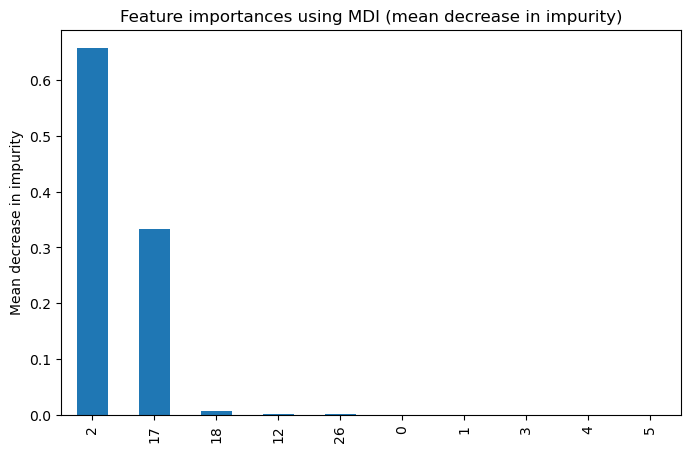

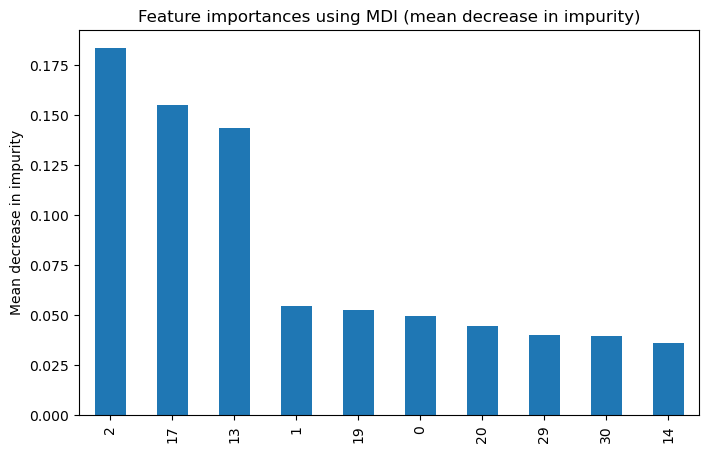

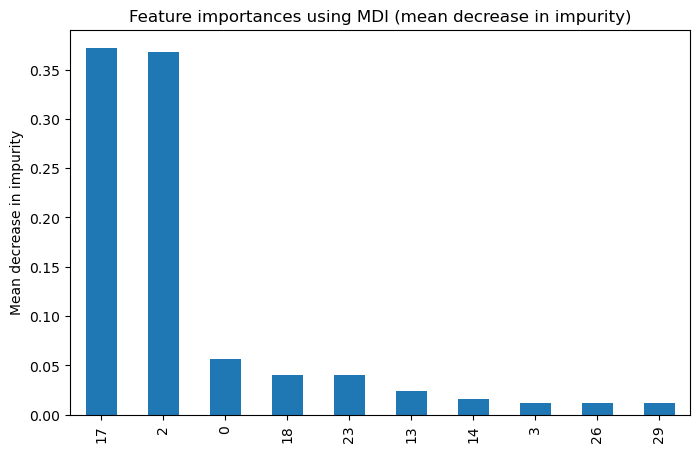

In [34]:
# Get plots
for i in range(len(clfs)):
    clf = clfs[i]
    print(f"Getting results for {clf_names[i]} model")
#     plot_roc_auc(clf)
    plot_importances(clf)